In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# Importing libraries
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Create a custom Dataset

class CustomCSVDataset(Dataset):
    def __init__(self, file_path, train=True, transform=None):
        self.data = pd.read_csv(file_path)
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.train:
            label = self.data.iloc[idx,0]
            data = self.data.iloc[idx, 1:].values.astype('float32')
            sample = {'label': label, 'data': data}
            
        else:
            data = self.data.iloc[idx].values.astype('float32')
            sample = {'data': data}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [5]:
# Custom transformations

def custom_transform(sample):
    if 'label' in sample:
        label = sample['label']
        data = sample['data']
    else:
        data = sample['data']
    
    if len(data.shape) == 1:
        data = data.reshape(28,28)
        
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ])
    
    data_normalized = transform(data)
    
    if 'label' in sample:
        return {'label': label, 'data': data_normalized}
    else:
        return {'data': data_normalized}

In [6]:
train_file_path = '/kaggle/input/digit-recognizer/train.csv'
test_file_path = '/kaggle/input/digit-recognizer/test.csv'

In [7]:
full_train_ds = CustomCSVDataset(train_file_path, train=True, transform=custom_transform)

# Splitting into training and validation sets
train_size = int(0.8* len(full_train_ds))
val_size = len(full_train_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_size, val_size])

test_ds = CustomCSVDataset(test_file_path, train=False, transform=custom_transform)

In [8]:
# Creating a DataLoader

BATCH_SIZE = 32
train_dl = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, shuffle=True, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

In [9]:
# Neural Network

class dr_custom_nn(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 *7 *7, 128)
        self.fc2 = nn.Linear(128, output_shape)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

In [10]:
LEARNING_RATE = 1e-3
input_shape = 28*28
output_shape = 10

custom_nn = dr_custom_nn(input_shape, output_shape).to(device)

# Loss function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=custom_nn.parameters(), lr = LEARNING_RATE)

In [11]:
# Training step

def train_step(model, input_dl, loss_fn, optimizer):
    model.train()
    train_loss, train_accuracy = 0,0

    for batch, data in enumerate(input_dl):
        X = data['data'].to(device)
        y = data['label'].to(device)
        preds = model(X)
        loss = loss_fn(preds, y)
        train_loss += loss.item()

        preds_classes = torch.argmax(torch.softmax(preds, dim=1), dim=1)
        train_accuracy += (preds_classes == y).sum().item()/len(preds)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/len(input_dl), (train_accuracy/len(input_dl))*100

In [12]:
# Validation step

def val_step(model, input_dl, loss_fn):
    model.eval()
    test_loss, test_accuracy = 0, 0
    
    torch.inference_mode()
    for data in input_dl:
        X = data['data'].to(device)
        y = data['label'].to(device)
        preds = model(X)
        loss = loss_fn(preds, y)
        test_loss += loss.item()

        preds_classes = torch.argmax(torch.softmax(preds, dim=1), dim=1)
        test_accuracy += (preds_classes == y).sum().item()/len(preds)

    return test_loss/len(input_dl), (test_accuracy/len(input_dl))*100

In [13]:
# Testing step

def test_step(model, input_dl, loss_fn):
    model.eval()
    test_loss, test_accuracy = 0, 0
    
    torch.inference_mode()
    for data in input_dl:
        X = data['data'].to(device)
        preds = model(X)
        loss = loss_fn(preds, y)
        test_loss += loss.item()

        preds_classes = torch.argmax(torch.softmax(preds, dim=1), dim=1)
        test_accuracy += (preds_classes == y).sum().item()/len(preds)

    return test_loss/len(input_dl), (test_accuracy/len(input_dl))*100

In [14]:
EPOCHS = 25

total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(custom_nn, train_dl, loss_fn, optimizer)
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    val_loss, val_acc = val_step(custom_nn, val_dl, loss_fn)
    total_val_loss.append(val_loss)
    total_val_acc.append(val_acc)
    print(f'EPOCH:{epoch+1} | Training Loss:{train_loss} | Training Accuracy:{train_acc} % | Test Loss:{val_loss} | Test Accuracy:{val_acc} %')

EPOCH:1 | Training Loss:0.2813725951421518 | Training Accuracy:94.21428571428572 % | Test Loss:0.08586212587803992 | Test Accuracy:97.46910646387833 %
EPOCH:2 | Training Loss:0.06330415191172506 | Training Accuracy:98.06845238095238 % | Test Loss:0.08281213874663786 | Test Accuracy:97.92062737642586 %
EPOCH:3 | Training Loss:0.050875425205997006 | Training Accuracy:98.41071428571428 % | Test Loss:0.08623323474647504 | Test Accuracy:97.81368821292776 %
EPOCH:4 | Training Loss:0.04577956286533706 | Training Accuracy:98.64583333333333 % | Test Loss:0.06879230400245917 | Test Accuracy:98.32461977186313 %
EPOCH:5 | Training Loss:0.03882008642230132 | Training Accuracy:98.83928571428572 % | Test Loss:0.08490697243417451 | Test Accuracy:97.77804182509506 %
EPOCH:6 | Training Loss:0.03841490919615656 | Training Accuracy:98.80357142857143 % | Test Loss:0.11130913530492077 | Test Accuracy:97.37404942965779 %
EPOCH:7 | Training Loss:0.02948798040591551 | Training Accuracy:99.13988095238095 % | Te

In [15]:
# Plot loss curve

def plot_loss_accuracy(epochs, loss, accuracy, color_map):
    plt.plot(range(epochs), loss, c=color_map)

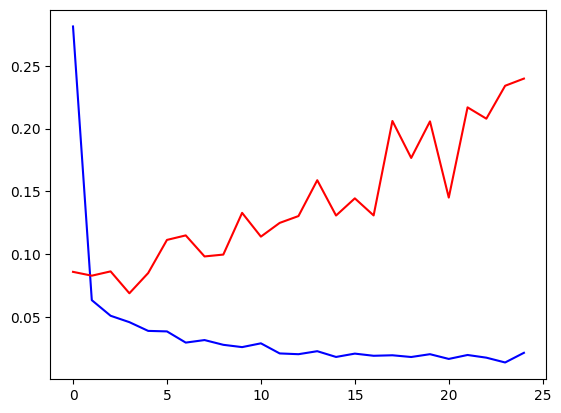

In [16]:
plot_loss_accuracy(EPOCHS, total_train_loss, total_train_acc, color_map='b')
plot_loss_accuracy(EPOCHS, total_val_loss, total_val_acc, color_map='r')

In [17]:
# Sample Submission

all_predictions = []

custom_nn.eval()
with torch.inference_mode():
    for data in test_dl:
        inputs = data['data'].to(device)
        outputs = custom_nn(inputs)
        _, predicted = torch.max(outputs.data,1)
        all_predictions.extend(predicted.tolist())

In [18]:
all_predictions[0:5]

[2, 0, 9, 9, 3]

In [19]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_ds)+1)[:,None], all_predictions], 
                      columns=['ImageId', 'Label'])

In [20]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [21]:
out_df.to_csv('submission.csv', index=False)